In [87]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from Tryba_Functions import scatter_with_subplots

# Data Import

In [88]:
# create dataframe
project_hours = pd.read_csv('project_hours_scaled.csv')

# change date columns to datetime
project_hours[['fund_date', 'start_date', 'finish_date']] = project_hours[['fund_date', 'start_date', 'finish_date']].astype('datetime64[s]')

# Cast id columns as integers
project_hours[['client_id', 'project_id']] = project_hours[['client_id', 'project_id']].astype('int')

# Exploratory Analysis

## Classifying Top Clients and Ranking all Clients
I'd like to determine a list of my top clients based on their average hourly rates and total project revenue.

In [89]:
# Filtering and Sorting Top Clients


# region Collecting Data

# Create hourly_ratio column based on each projects ratio of all hourly 
project_hours['hourly_ratio'] = project_hours['project_hourly'].apply(lambda x: x/project_hours['project_hourly'].sum())

# Create per_project_ratio column based on each projects ratio of income
project_hours['per_project_ratio'] = project_hours['total_after_fees'].apply(lambda x: x/project_hours['total_after_fees'].sum())

# Filter only finished projects that are time tracked
finished_tracked_projects = project_hours[(project_hours['status'].str.lower() == 'done')
                                            & (project_hours['spec_project'] == False)
                                            & (project_hours['time_tracked'] == True)]

# Aggregate function to group client_id and average their hourly and ratio of total per_project_ratio
client_ranking = finished_tracked_projects.groupby('client_id').agg(
    average_hourly_ratio=('hourly_ratio', 'mean'),  # Calculate the average of hourly_ratio
    total_per_project_ratio=('per_project_ratio', 'sum')  # Calculate the sum of per_project_ratio
).reset_index()

# Use the rename method to alias column names
client_ranking = client_ranking.rename(columns={
    'average_hourly_ratio': 'client_hourly_average',
    'total_per_project_ratio': 'client_project_revenue_ratio'
})

# endregion

# region Categorize Percentiles

# Set thresholds 
hourly_threshold_pct = 50
per_project_threshold_pct = 75

# Get 80th percentile values
percentile_value_hourly = np.percentile(client_ranking['client_hourly_average'], hourly_threshold_pct)
percentile_value_project = np.percentile(client_ranking['client_project_revenue_ratio'], per_project_threshold_pct)

# Function to assign percentile labels to hourly
def top_percentile_bool_hourly(value):
    if np.percentile(value, hourly_threshold_pct) >= percentile_value_hourly:
        return True
    else:
        return False

# Function to assign percentile labels to projects
def top_percentile_bool_project(value):
    if np.percentile(value, per_project_threshold_pct) >= percentile_value_project:
        return True
    else:
        return False

# Categorize top_hourly_clients
client_ranking['top_client_hourly'] = client_ranking['client_hourly_average'].apply(top_percentile_bool_hourly)

# Categorize top_per_project_clients
client_ranking['top_client_per_project'] = client_ranking['client_project_revenue_ratio'].apply(top_percentile_bool_project)

# Assign percentile values for overall ratings
percentiles = [25, 50, 75]
percentile_values_hourly = np.percentile(client_ranking['client_hourly_average'], percentiles)

# Function to assign percentile labels
def assign_percentile_label_hourly(value):
    percentile_x = np.percentile(value, hourly_threshold_pct)
    if percentile_x <= percentile_values_hourly[0]:
        return '25th Percentile'
    elif percentile_x <= percentile_values_hourly[1]:
        return '50th Percentile'
    elif percentile_x <= percentile_values_hourly[2]:
        return '75th Percentile'
    else:
        return 'Above 75th Percentile'
    
# Function to assign percentile labels
def assign_percentile_label_project(value):
    percentile_y = np.percentile(value, per_project_threshold_pct)
    if percentile_y <= percentile_values_project[0]:
        return '25th Percentile'
    elif percentile_y <= percentile_values_project[1]:
        return '50th Percentile'
    elif percentile_y <= percentile_values_project[2]:
        return '75th Percentile'
    else:
        return 'Above 75th Percentile'
    
client_ranking['hourly_avg_percentile'] = client_ranking['client_hourly_average'].apply(assign_percentile_label_hourly)

percentile_values_project = np.percentile(client_ranking['client_project_revenue_ratio'], percentiles)

client_ranking['per_project_percentile'] = client_ranking['client_project_revenue_ratio'].apply(assign_percentile_label_project)

# endregion

# region Organize dataframes

# Sort dataframe by ratios
client_ranking = client_ranking.sort_values(by=['client_project_revenue_ratio', 'client_hourly_average'], ascending=False, ignore_index=True)

# Create top_client column
client_ranking['top_client'] = client_ranking['top_client_hourly'] & client_ranking['top_client_per_project']
#client_ranking['client_rank'] = client_ranking.index + 1

# Create dataframe of only top clients for dashboard
top_clients = client_ranking[client_ranking['top_client'] == True].reset_index(drop=True)
top_clients = top_clients[['client_id']]
top_clients['ranking'] = top_clients.index + 1
top_clients
# endregion


,client_id,ranking
0,17,1
1,13,2
2,73,3
3,5,4
4,51,5
5,40,6
6,37,7
7,41,8


In [90]:
# region Merge to original dataframe
client_ranking_filtered = client_ranking[['client_id', 'hourly_avg_percentile', 'per_project_percentile', 'top_client']]
project_hours_ranked = pd.merge(project_hours, client_ranking_filtered, how='left', on='client_id')
project_hours_ranked
# end region

,fund_date,start_date,finish_date,price,total_additional_payments,expenses,total_after_fees,total_hours,status,project_type,...,project_hourly,days_to_finish,days_to_start,client_id,project_id,hourly_ratio,per_project_ratio,hourly_avg_percentile,per_project_percentile,top_client
0,NaT,2020-09-02,2020-09-09,NaN,NaN,NaN,NaN,25.48,Done,full production,...,NaN,7.0,NaN,1,139,NaN,NaN,NaN,NaN,NaN
1,NaT,NaT,2018-08-08,NaN,NaN,NaN,NaN,NaN,Done,full production,...,NaN,NaN,NaN,2,144,NaN,NaN,NaN,NaN,NaN
2,NaT,NaT,2018-10-24,NaN,NaN,NaN,NaN,NaN,Done,full production,...,NaN,NaN,NaN,2,145,NaN,NaN,NaN,NaN,NaN
3,NaT,NaT,2018-09-09,NaN,NaN,NaN,NaN,NaN,Done,full production,...,NaN,NaN,NaN,2,143,NaN,NaN,NaN,NaN,NaN
4,NaT,2022-01-06,2022-03-14,NaN,NaN,NaN,NaN,0.00,Done,full production,...,NaN,67.0,NaN,3,133,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,NaT,NaT,2022-06-10,NaN,NaN,NaN,NaN,NaN,Done,full production,...,NaN,NaN,NaN,91,216,NaN,NaN,NaN,NaN,NaN
234,NaT,NaT,2021-10-12,NaN,NaN,NaN,NaN,NaN,Done,full production,...,NaN,NaN,NaN,91,206,NaN,NaN,NaN,NaN,NaN
235,NaT,NaT,2021-04-08,NaN,NaN,NaN,NaN,NaN,Done,full production,...,NaN,NaN,NaN,91,217,NaN,NaN,NaN,NaN,NaN
236,2021-11-24,2021-12-23,2022-01-09,0.400000,0.093333,NaN,0.454411,13.96,Done,full production,...,0.032552,17.0,29.0,92,114,0.009400,0.013413,Above 75th Percentile,75th Percentile,False


## Pricing Visualizations


In [91]:
# Filter 'project_hours' by projects that are marked 'Done'

project_hours_tracked_paid = project_hours[(project_hours['status'].str.lower() == 'done') 
                                      & (project_hours['time_tracked'] == True)
                                      & (project_hours['spec_project'] == False)] 
project_hours_done_full_production_paid = project_hours[(project_hours['project_type'].str.lower() == 'full production') 
                                                       & (project_hours['status'].str.lower() == 'done')
                                                       & (project_hours['spec_project'] == False)
                                                       & (project_hours['time_tracked'] == True)]

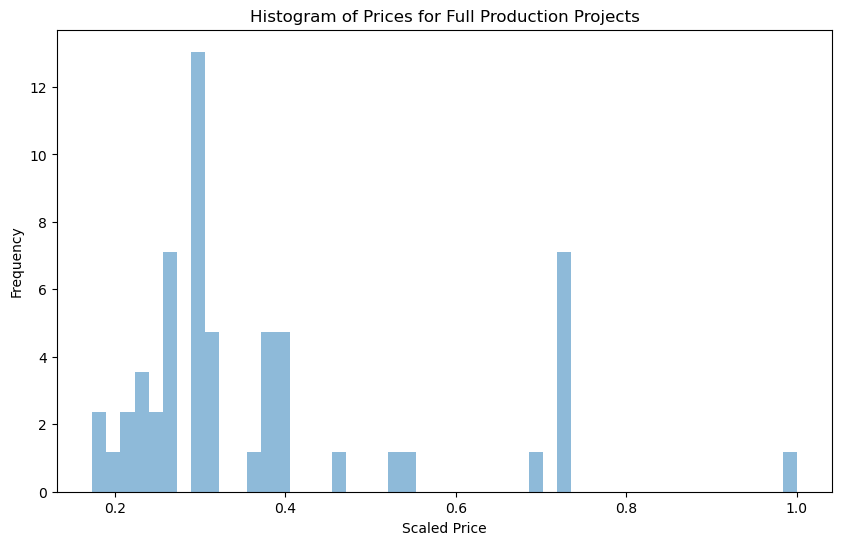

In [92]:
#Histogram of prices on finished full production projects

plt.figure(figsize=(10,6))
plt.hist(project_hours_done_full_production_paid['price'], density=True, bins=50, alpha = 0.5)

ax = plt.subplot()
title = 'Histogram of Prices for Full Production Projects'
plt.title(title)
plt.xlabel('Scaled Price')
plt.ylabel('Frequency')
plt.savefig(os.path.join('Visualizations', title))
plt.show()

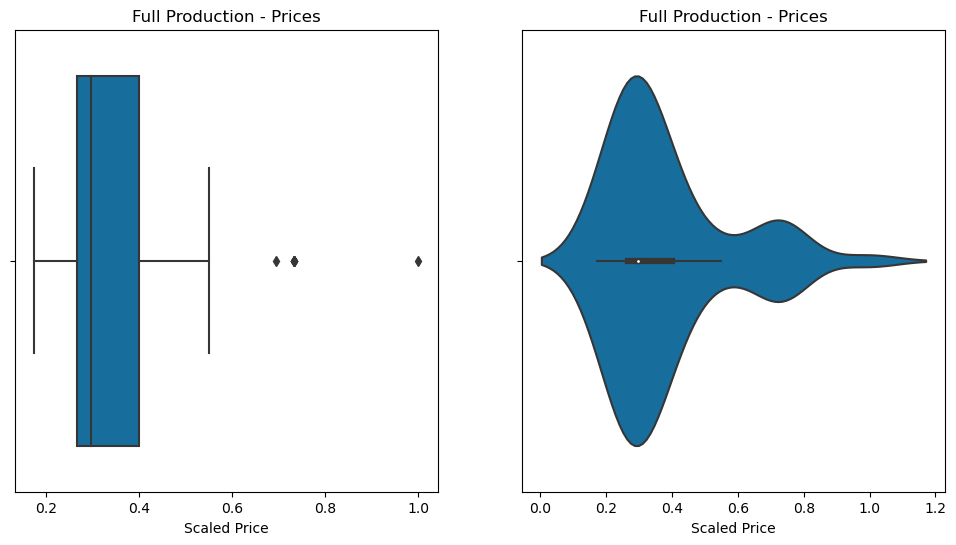

In [93]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
color_palette = "colorblind"
sns.set_palette(color_palette)
sns.boxplot(x='price', data = project_hours_done_full_production_paid)
plt.xlabel('Scaled Price')
plt.title('Full Production - Prices')

plt.subplot(1,2,2)
color_palette = "colorblind"
sns.set_palette(color_palette)
sns.violinplot(x='price', data = project_hours_done_full_production_paid)
plt.xlabel('Scaled Price')
plt.title('Full Production - Prices')
title = 'Full Production Prices Box and Violin Plots'
plt.savefig(os.path.join('Visualizations', title))
plt.show()

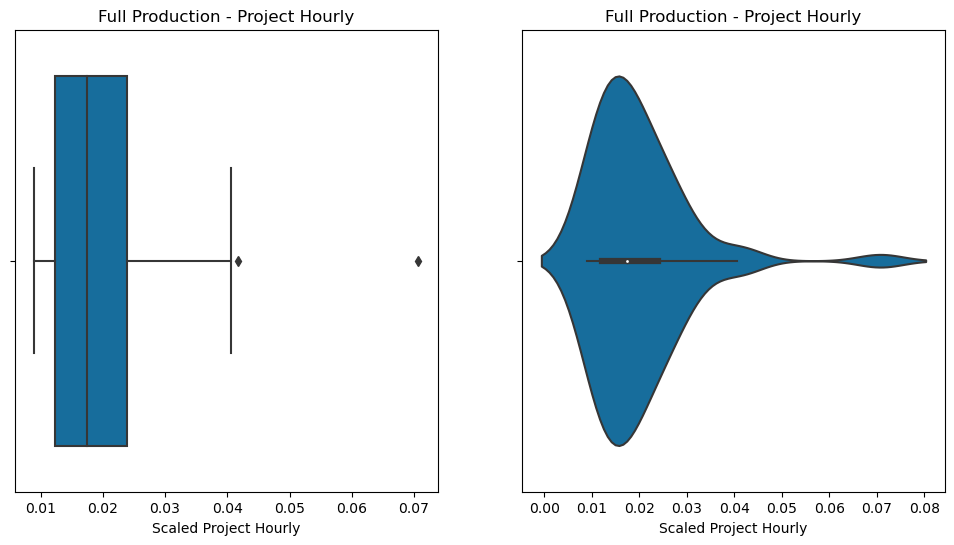

In [94]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
color_palette = "colorblind"
sns.set_palette(color_palette)
sns.boxplot(x='project_hourly', data = project_hours_done_full_production_paid)
plt.xlabel('Scaled Project Hourly')
plt.title('Full Production - Project Hourly')

plt.subplot(1,2,2)
sns.violinplot(x='project_hourly', data = project_hours_done_full_production_paid)
plt.xlabel('Scaled Project Hourly')
plt.title('Full Production - Project Hourly')
title = 'Full Production Project Hourly Box and Violin Plots'
plt.savefig(os.path.join('Visualizations', title))
plt.show()

In [95]:
project_hours_tracked_paid.describe()

,fund_date,start_date,finish_date,price,total_additional_payments,expenses,total_after_fees,total_hours,master_ownership,song_ownership,project_hourly,days_to_finish,days_to_start,client_id,project_id,hourly_ratio,per_project_ratio
count,93,93,93,93.000000,21.000000,15.000000,93.000000,93.000000,10.00000,2.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,2021-07-29 08:00:00,2021-09-08 19:21:17,2021-12-22 08:15:29,0.293405,0.062222,0.032088,0.288887,15.003871,0.10900,0.375000,0.023789,104.537634,41.473118,43.763441,71.290323,0.006870,0.008527
min,2019-09-03 00:00:00,2020-02-03 00:00:00,2020-04-06 00:00:00,0.020000,0.005925,0.004229,0.018021,0.230000,0.00000,0.250000,0.008939,1.000000,0.000000,4.000000,2.000000,0.002581,0.000532
25%,2020-09-10 00:00:00,2020-11-23 00:00:00,2021-02-16 00:00:00,0.186667,0.005925,0.013429,0.160000,8.910000,0.00000,0.312500,0.013275,25.000000,2.000000,17.000000,52.000000,0.003833,0.004723
50%,2021-02-25 00:00:00,2021-05-30 00:00:00,2021-12-20 00:00:00,0.253333,0.013333,0.019467,0.251467,14.700000,0.01500,0.375000,0.018568,58.000000,13.000000,38.000000,75.000000,0.005362,0.007423
75%,2022-07-06 00:00:00,2022-07-07 00:00:00,2022-11-10 00:00:00,0.320000,0.093333,0.031200,0.368440,20.370000,0.03000,0.437500,0.026339,123.000000,40.000000,76.000000,99.000000,0.007606,0.010876
max,2023-10-16 00:00:00,2023-10-24 00:00:00,2023-11-07 00:00:00,1.000000,0.253333,0.160000,0.901101,34.560000,0.50000,0.500000,0.082232,639.000000,423.000000,92.000000,123.000000,0.023746,0.026599
std,NaN,NaN,NaN,0.186146,0.076154,0.039419,0.181275,8.734022,0.20653,0.176777,0.015550,126.440789,69.659980,28.600470,33.590106,0.004490,0.005351


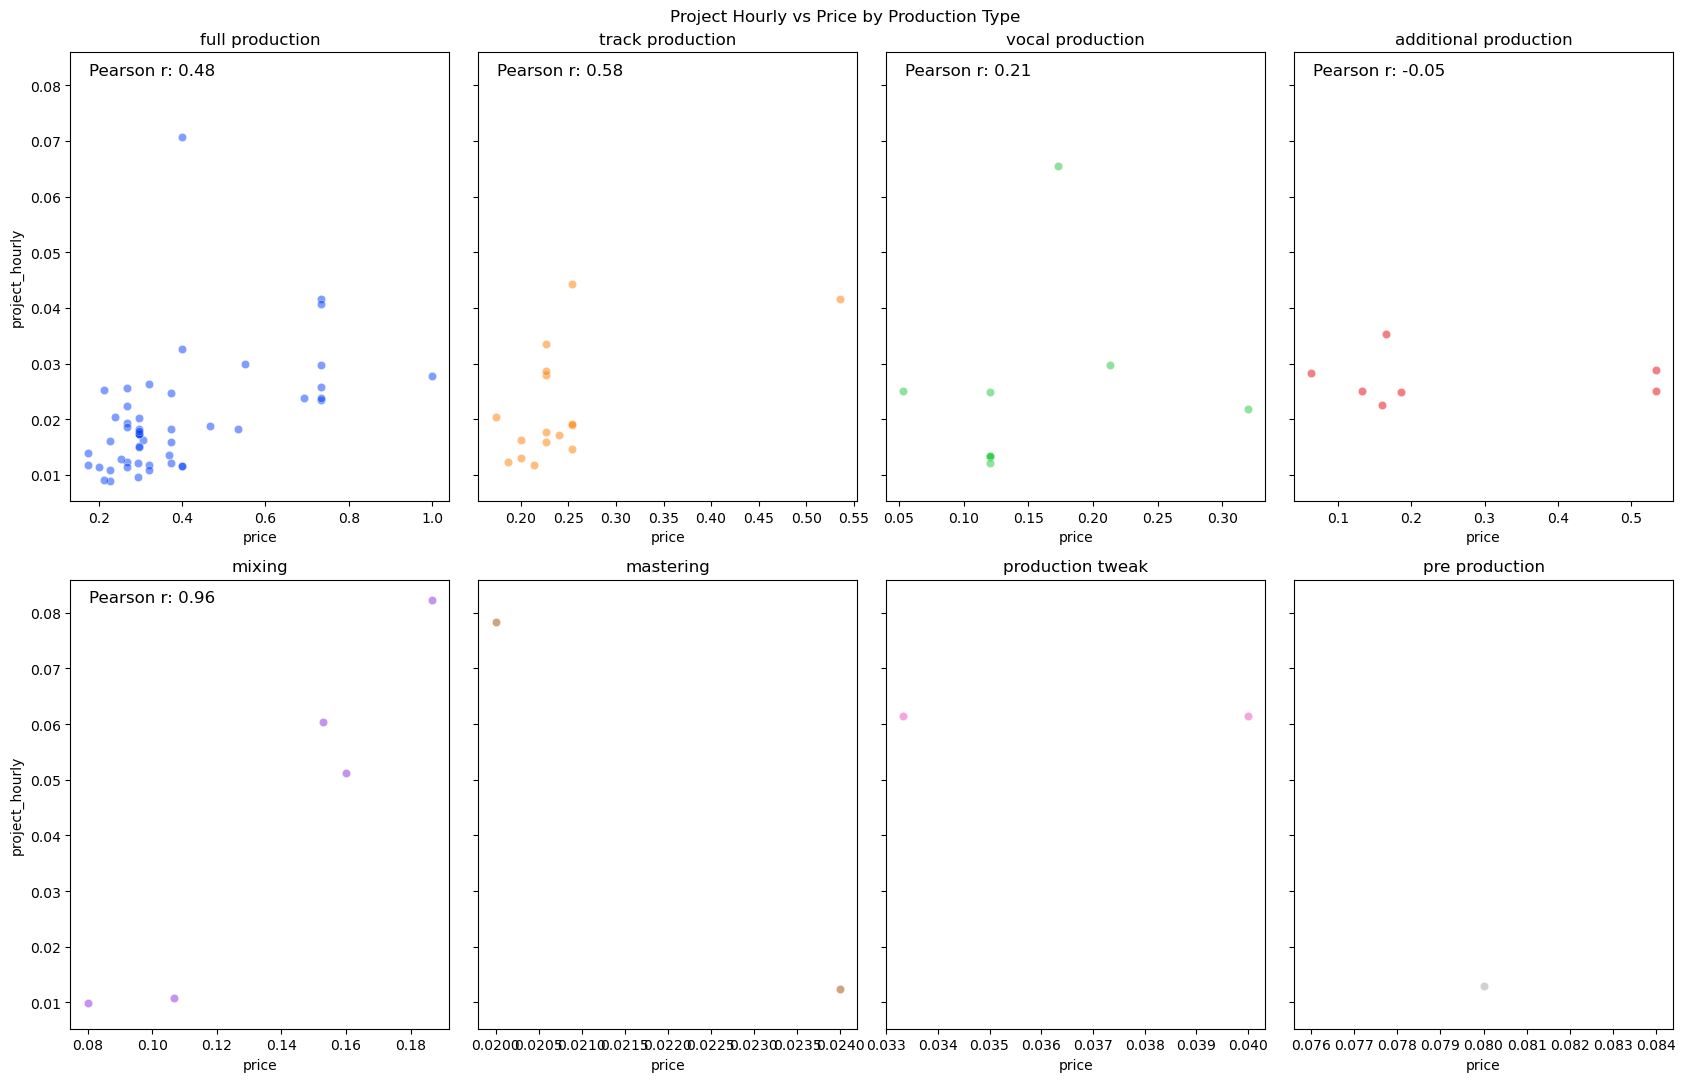

In [96]:
scatter_with_subplots(project_hours_tracked_paid, 'price', 'project_hourly', 'project_type', 'bright', 17, 11, 'Project Hourly vs Price by Production Type')

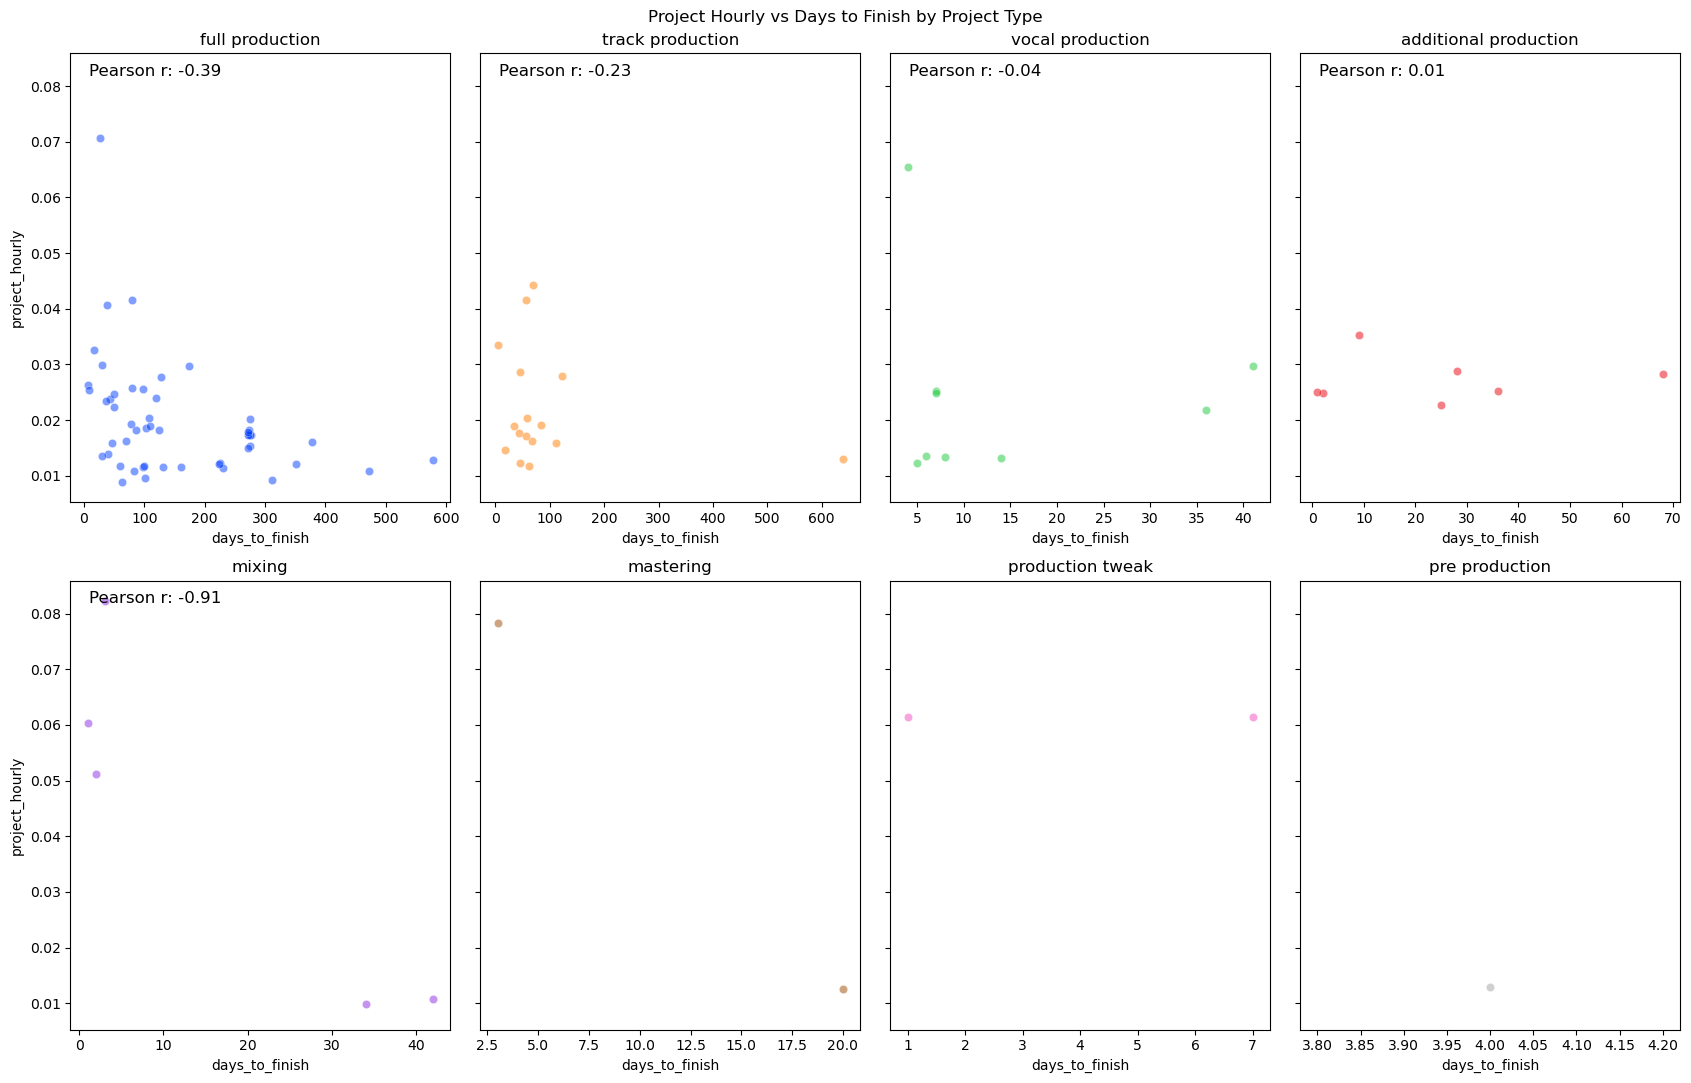

In [97]:
# Is there a correlation between days to finish a project and project hourly?
scatter_with_subplots(project_hours_tracked_paid, 'days_to_finish', 'project_hourly', 'project_type', 'bright', 17, 11, 'Project Hourly vs Days to Finish by Project Type')

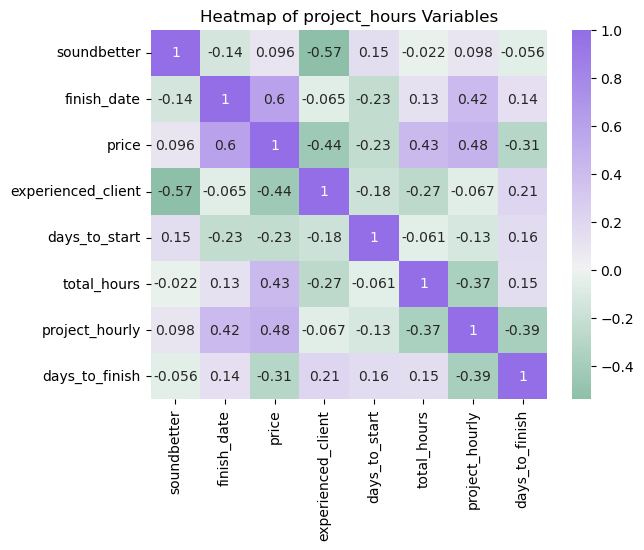

In [98]:
# Heatmap of project_hours_done
colors = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
# Create heatmap using the .corr method on df, set colormap to cmap
sns.heatmap(project_hours_done_full_production_paid[['soundbetter', 'finish_date', 'price', 'experienced_client', 'days_to_start',
                                'total_hours', 'project_hourly', 'days_to_finish']].corr(), center=0, cmap=colors, robust=True, annot=True)
title = 'Heatmap of project_hours Variables'
plt.title(title)
plt.savefig(os.path.join('Visualizations', title))
plt.show()

/Users/matthewtryba/anaconda3/envs/tryba-env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


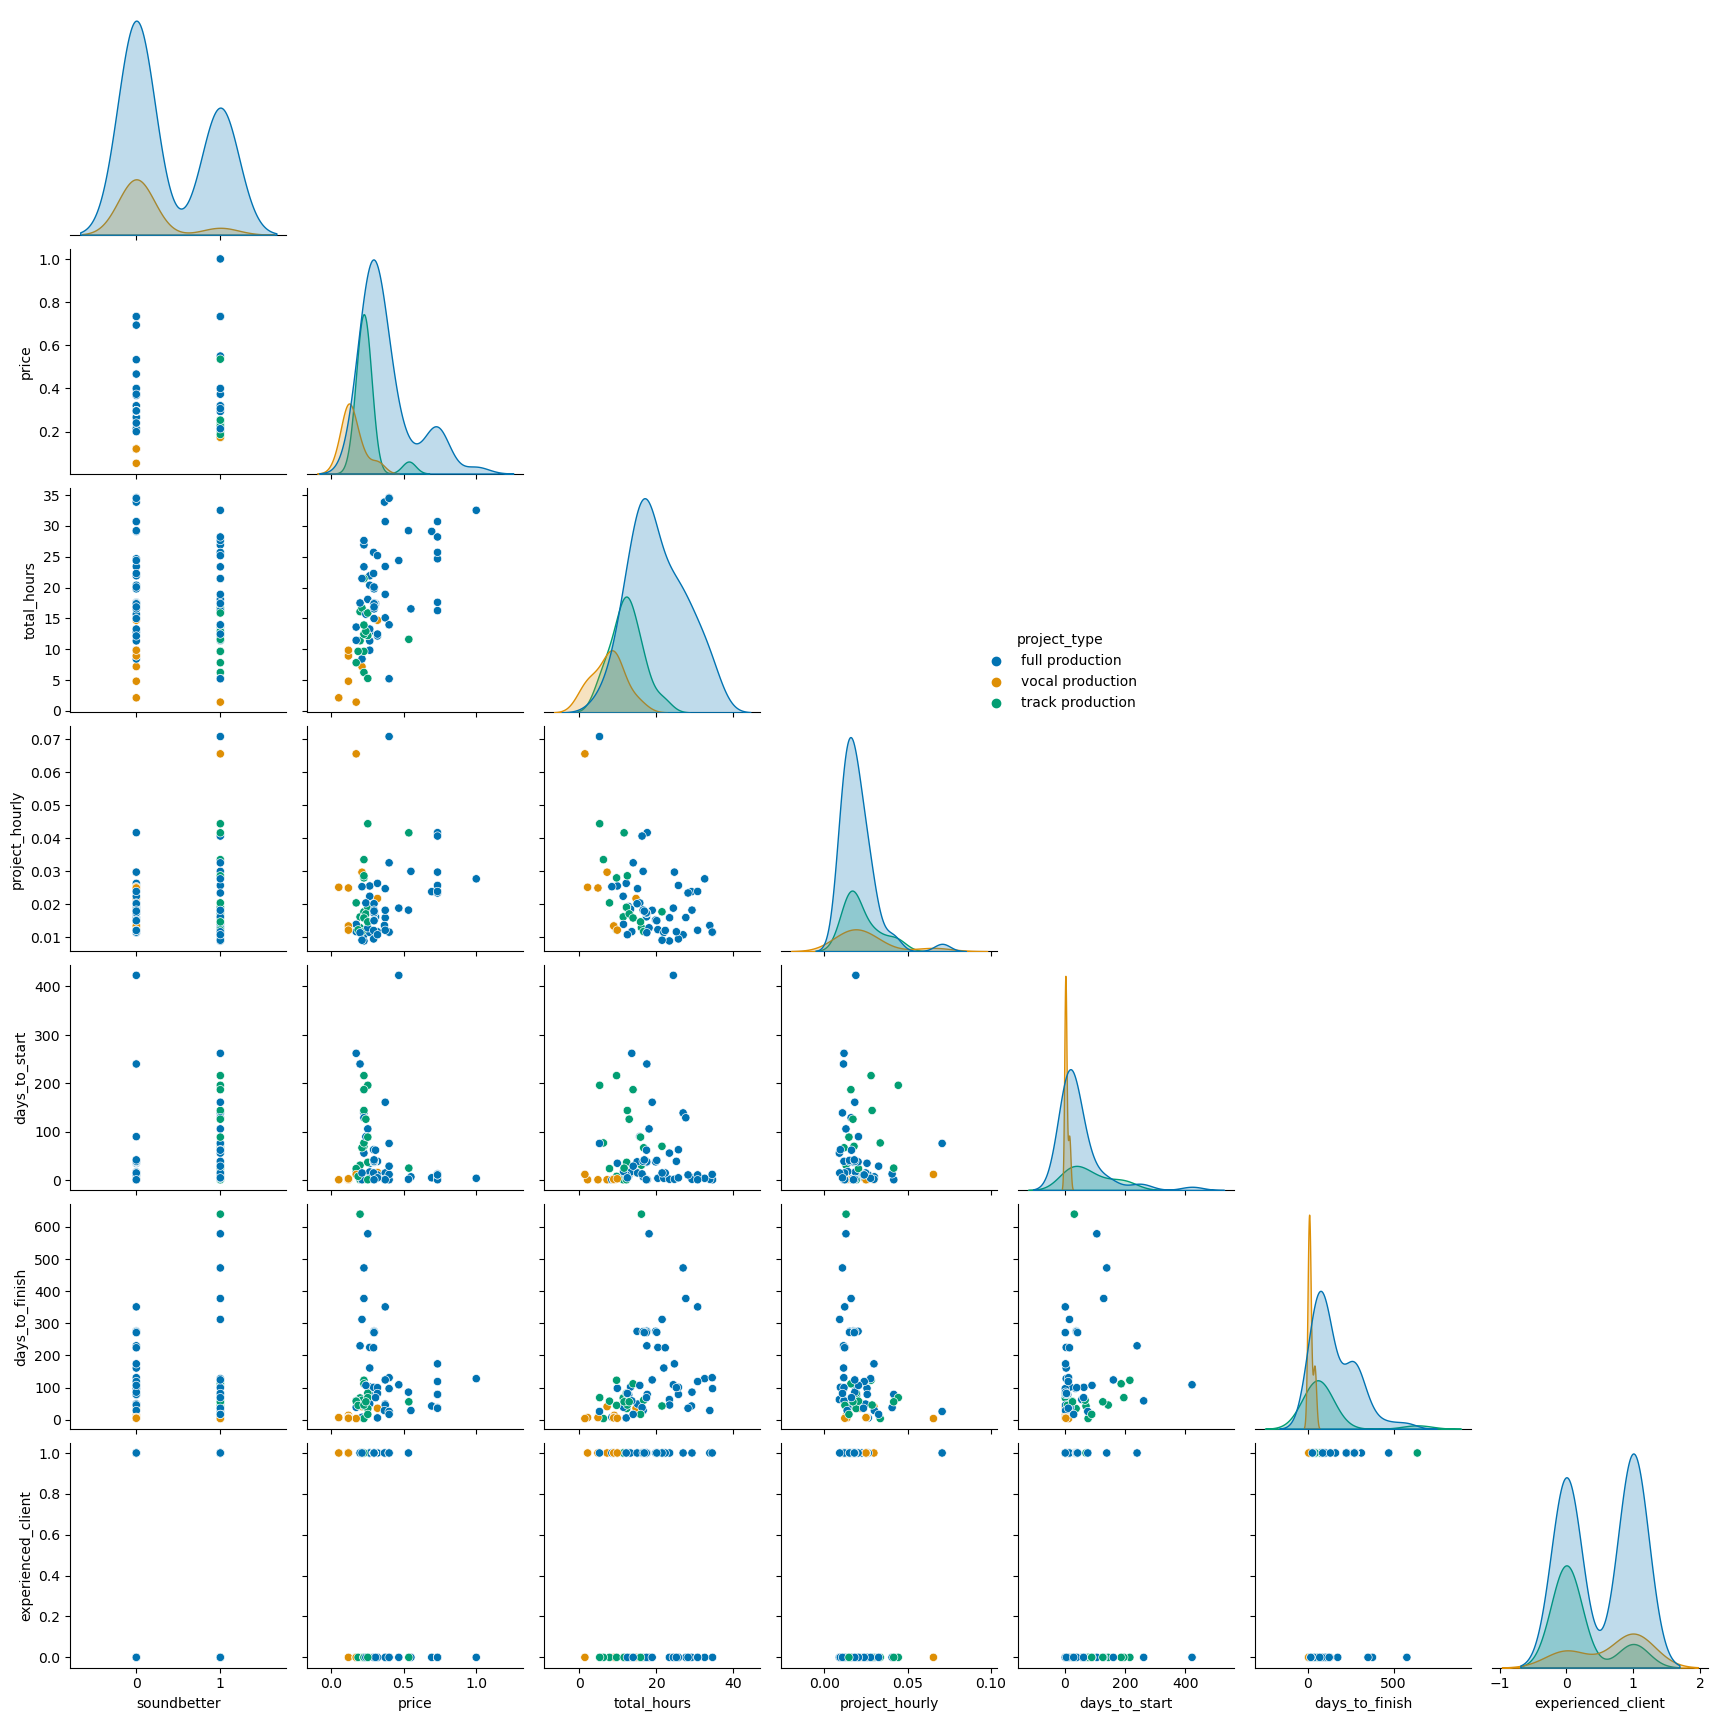

In [99]:
# pairplot different project types to screen for possible correlations
activity_list = ['full production', 'vocal production', 'track production']
project_hours_done_filtered_project_type = project_hours_tracked_paid[project_hours_tracked_paid['project_type'].isin(activity_list)]

plot_data = project_hours_done_filtered_project_type[['soundbetter', 'fund_date', 'finish_date', 'price', 
                                                      'project_type', 'total_hours', 'project_hourly', 'days_to_start', 'days_to_finish', 'experienced_client']]

#Create Pairplots
pair_plot = sns.pairplot(plot_data, hue='project_type', palette='colorblind', corner=True)
pair_plot._legend.set_bbox_to_anchor((0.6, 0.6))  # Adjust the position of the legend
pair_plot.tight_layout()
title = 'Pairplot of project_hours'
plt.savefig(os.path.join('Visualizations', title))
plt.show()

## Analyzing Days Between Project Funding

In [100]:
# Create and filter dataframe
fund_dates = project_hours[['fund_date', 'total_after_fees', 'client_id']]
fund_dates = fund_dates.sort_values(by='fund_date', ascending=True).reset_index(drop = True)
fund_dates = fund_dates[fund_dates['fund_date'] > '2018-12-31']
fund_dates['days_between'] = 0
fund_dates['deposit'] = round(fund_dates['total_after_fees']/2, 2)

# iterate through fund_date and calculate the days between each successive date
for i in range(len(fund_dates)):
    if i == 0:
        fund_dates.loc[i, 'days_between'] = 0
    else:
        fund_dates.loc[i, 'days_between'] = (fund_dates.loc[i, 'fund_date'] - fund_dates.loc[i-1, 'fund_date']).days

fund_dates.head()

,fund_date,total_after_fees,client_id,days_between,deposit
1,2019-09-03,0.459627,20.0,NaN,0.23
2,2019-10-10,0.221064,44.0,37.0,0.11
3,2019-12-09,0.208784,4.0,60.0,0.10
4,2020-01-16,0.294752,58.0,38.0,0.15
5,2020-02-13,0.233347,19.0,28.0,0.12


In [101]:
''' I need to figure out how to combine rows into one sum if the artist is the same name on a given fund date
to address projects that had multiple songs funded that day'''

agg_dict = {
    'total_after_fees': 'sum',
    'days_between': 'first'  # You can use 'first' to carry the first value of days_between
}

collapsed_fund_dates = fund_dates.groupby(['fund_date', 'client_id'], as_index=False).agg(agg_dict)
collapsed_fund_dates['deposit'] = round(collapsed_fund_dates['total_after_fees']/2, 2)
collapsed_fund_dates.head()

,fund_date,client_id,total_after_fees,days_between,deposit
0,2019-09-03,20.0,0.459627,NaN,0.23
1,2019-10-10,44.0,0.221064,37.0,0.11
2,2019-12-09,4.0,0.208784,60.0,0.10
3,2020-01-16,58.0,0.294752,38.0,0.15
4,2020-02-13,19.0,0.233347,28.0,0.12


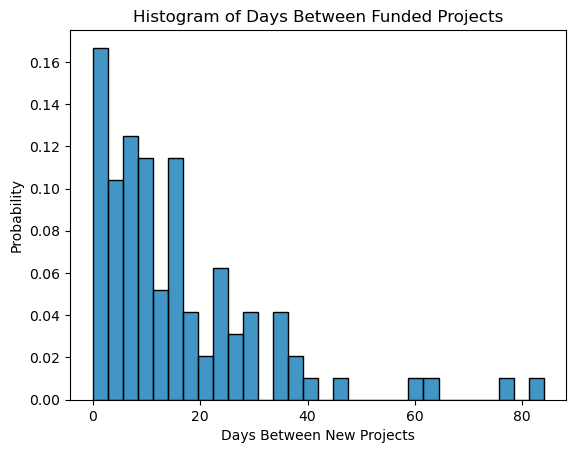

In [102]:
sns.histplot(data = collapsed_fund_dates, x = 'days_between', bins = 30, kde=False,stat='probability')
plt.style.use('default')
title = 'Histogram of Days Between Funded Projects'
plt.title(title)
plt.xlabel('Days Between New Projects')
plt.savefig(os.path.join('Visualizations', title))
plt.show()

In [103]:
collapsed_fund_dates.head()

,fund_date,client_id,total_after_fees,days_between,deposit
0,2019-09-03,20.0,0.459627,NaN,0.23
1,2019-10-10,44.0,0.221064,37.0,0.11
2,2019-12-09,4.0,0.208784,60.0,0.10
3,2020-01-16,58.0,0.294752,38.0,0.15
4,2020-02-13,19.0,0.233347,28.0,0.12


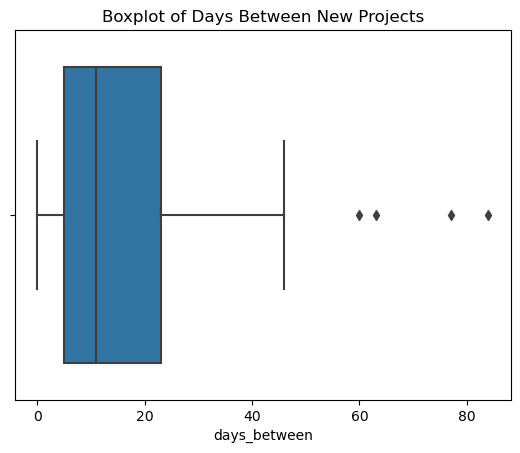

Median is 11.0 and mean is 15.666666666666666


In [104]:
sns.boxplot(data = collapsed_fund_dates, x= 'days_between')
title = 'Boxplot of Days Between New Projects'
plt.title(title)
plt.savefig(os.path.join('Visualizations', title))
plt.show()

median_days = collapsed_fund_dates['days_between'].median()
mean_days = collapsed_fund_dates['days_between'].mean()

print(f'Median is {median_days} and mean is {mean_days}')

#### Create bar graph with filler dates to visualize frequency of deposits

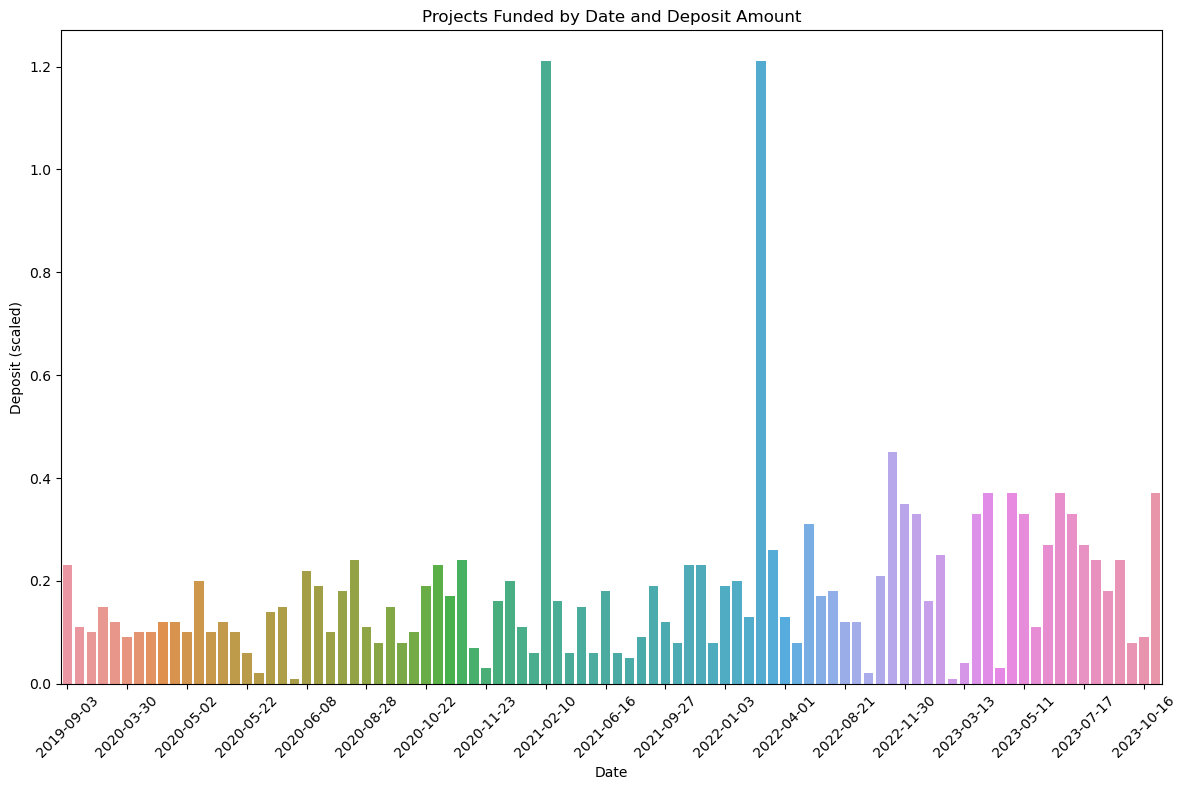

In [105]:
# Bar Graph without filler dates

funding_money_in = collapsed_fund_dates.groupby('fund_date')['deposit'].sum().reset_index()

plt.figure(figsize=(12, 8))
ax = sns.barplot(data= funding_money_in, x = 'fund_date', y = 'deposit')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Choose a subset of x-axis tick locations and labels for better visibility
x_tick_indices = range(0, len(funding_money_in), 5)  # Show every nth date
x_tick_labels = funding_money_in.loc[x_tick_indices, 'fund_date'].dt.strftime('%Y-%m-%d')

ax.set_xticks(x_tick_indices)
ax.set_xticklabels(x_tick_labels)
title = 'Projects Funded by Date and Deposit Amount'
plt.title(title)
plt.xlabel('Date')
plt.ylabel('Deposit (scaled)')
plt.tight_layout()
plt.savefig(os.path.join('Visualizations', title))
plt.show()

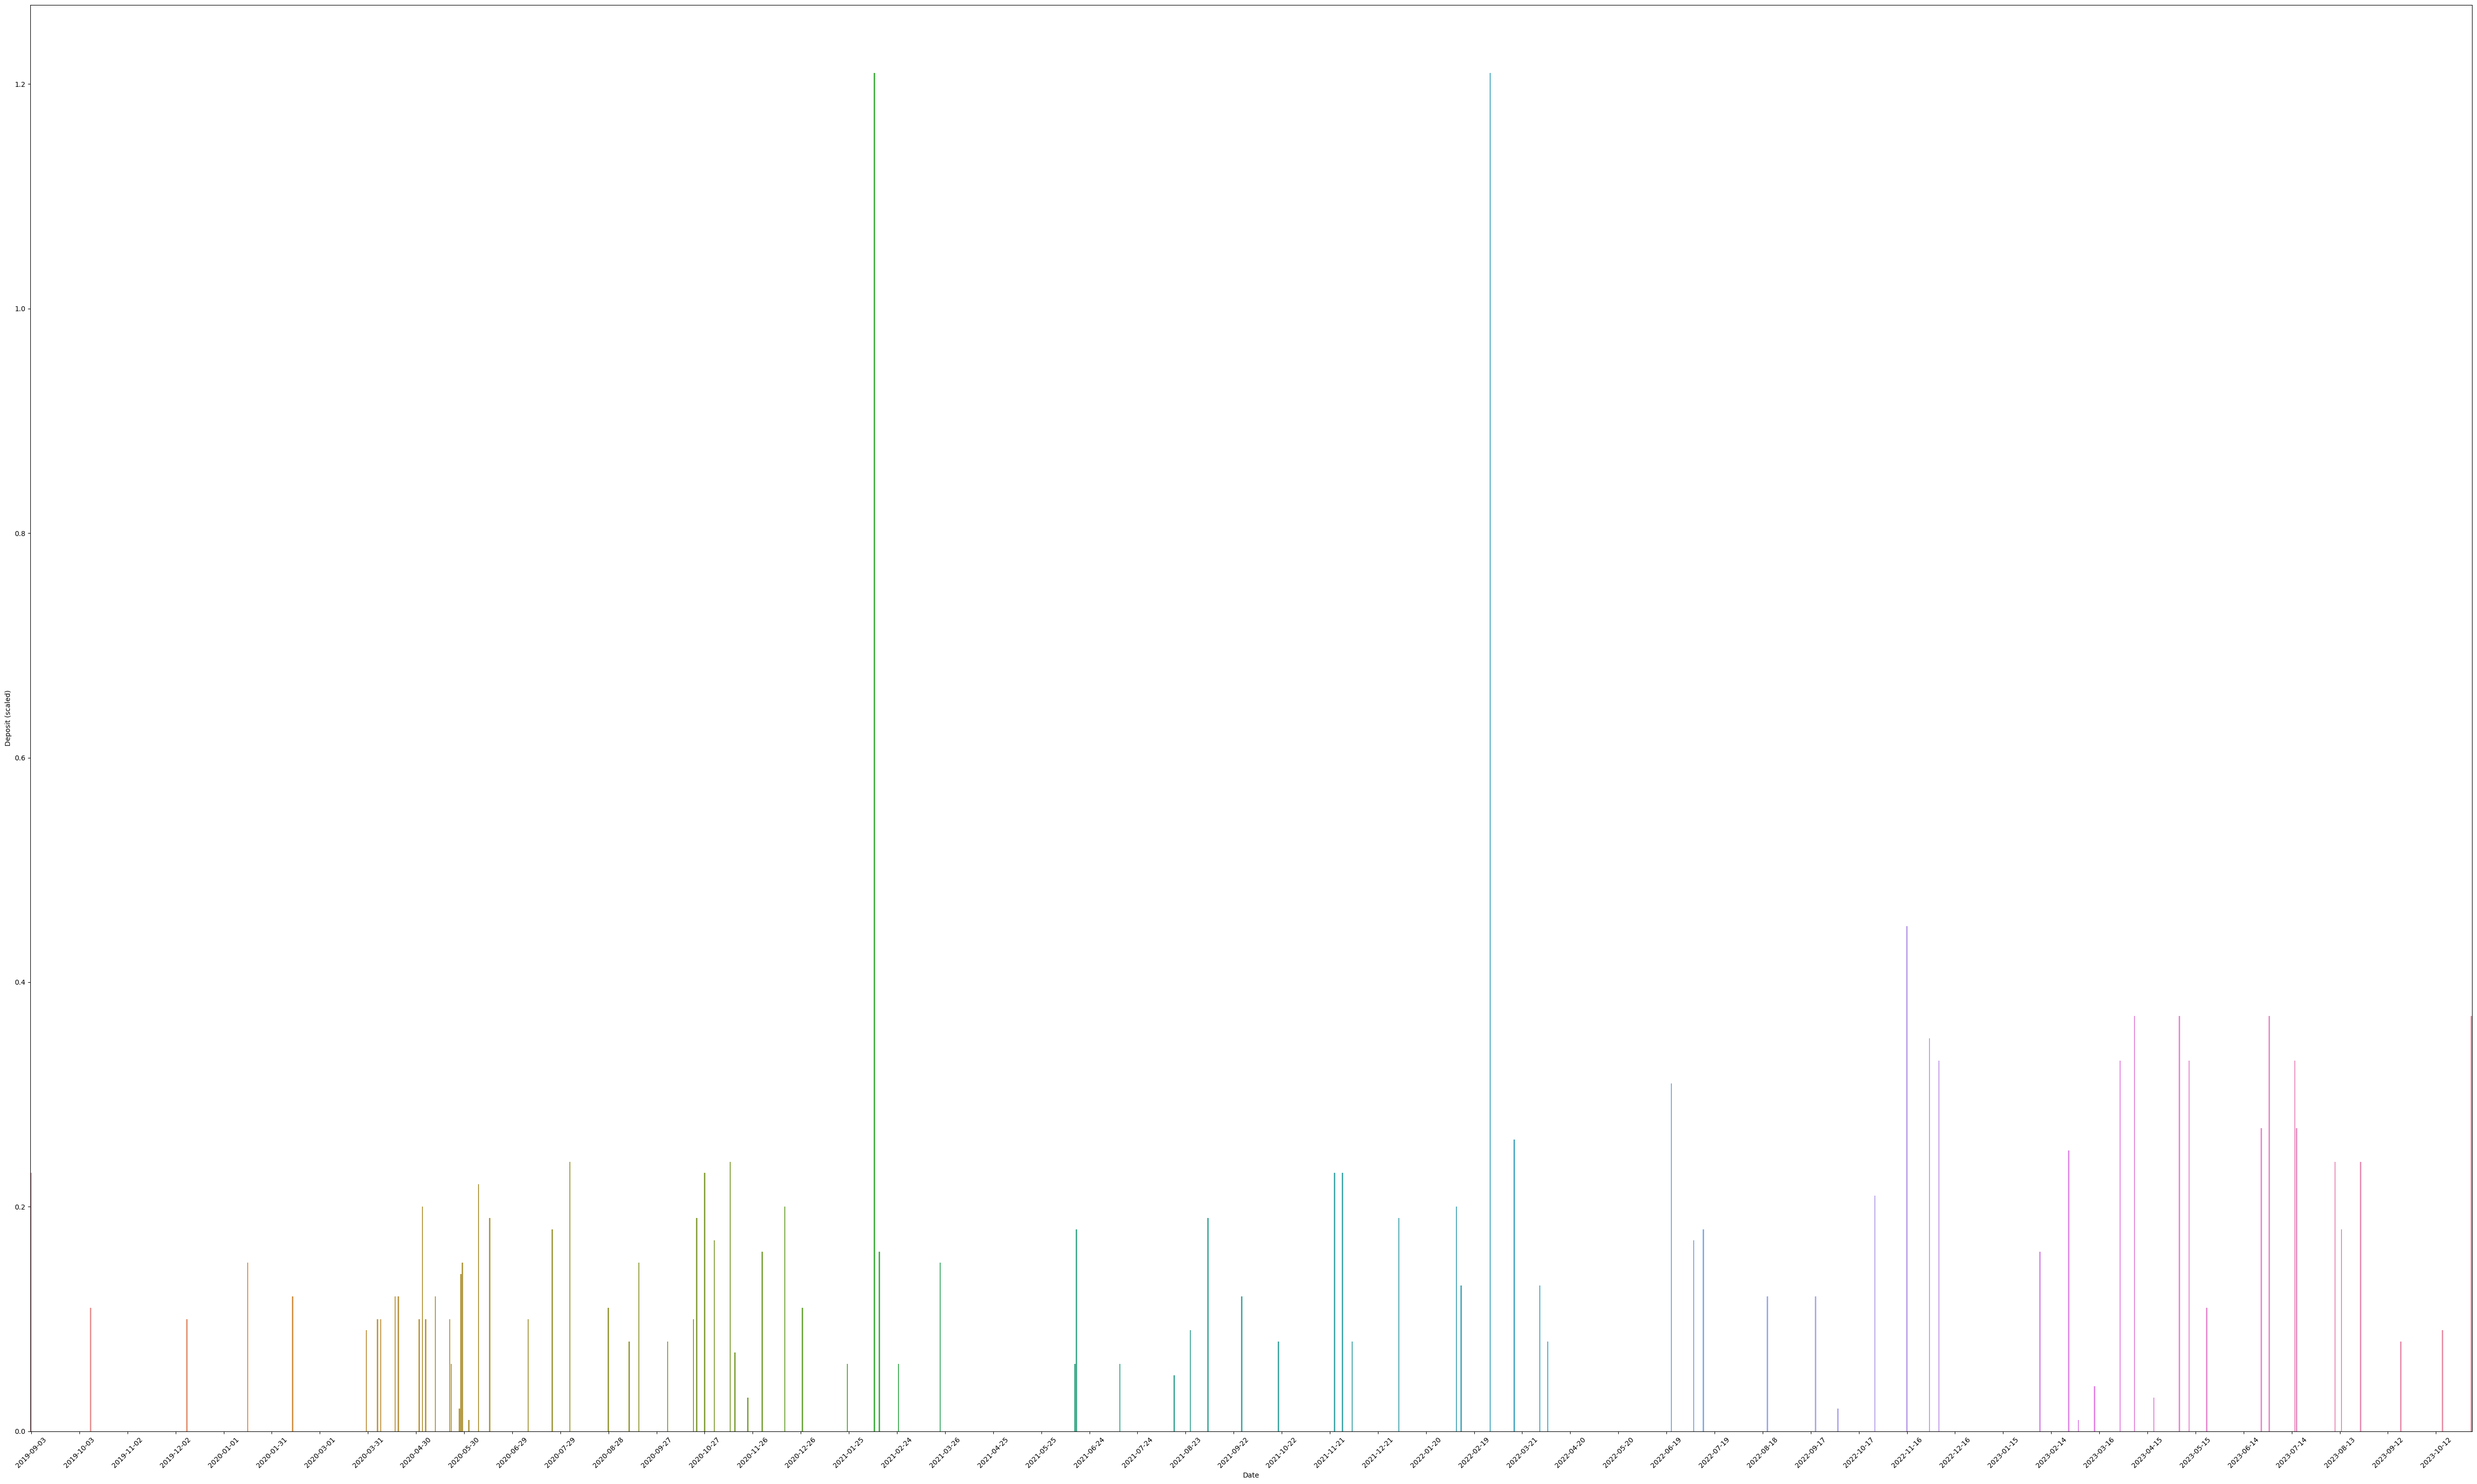

In [106]:
# The below graph gives a sense of how the deposits are spread through time

# Determine Date Range
fund_date_min = fund_dates['fund_date'].min()
fund_date_max = fund_dates['fund_date'].max()
date_range = pd.date_range(start = fund_date_min, end = fund_date_max, freq='D')

# Create dataframe of just dates within range
temp_df = pd.DataFrame({'fund_date': date_range})

# Left merge data frames on 'fund_date' and fill missing with 0
new_calendar_df = temp_df.merge(funding_money_in, on='fund_date', how='left').fillna(0)

# create figure
plt.figure(figsize=(50, 30)) # needs to be very large in order to see bars
ax = sns.barplot(data= new_calendar_df, x = 'fund_date', y = 'deposit')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Choose a subset of x-axis tick locations and labels for better visibility
x_tick_indices = range(0, len(new_calendar_df), 30)  # Show every nth date
x_tick_labels = new_calendar_df.loc[x_tick_indices, 'fund_date'].dt.strftime('%Y-%m-%d')

ax.set_xticks(x_tick_indices)
ax.set_xticklabels(x_tick_labels)
title = 'Projects Funded By Date with Filler Days'
plt.xlabel('Date')
plt.ylabel('Deposit (scaled)')
plt.tight_layout()
plt.savefig(os.path.join('Visualizations', title))
plt.show()

# Evaluating 'Business Hunches'

## How likely is a Soundbetter Client to be experienced?

Null hypothesis: there is no association between a client being from Soundbetter and their experience level.

In [107]:
# Create crosstab
Xtab = pd.crosstab(project_hours['soundbetter'], project_hours['experienced_client'])

chi2, pval, dof, expected = chi2_contingency(Xtab)
print(f'The p-value is {pval}')

The p-value is 2.6457554541268817e-26


In [108]:
Xtab = pd.crosstab(project_hours['soundbetter'], project_hours['experienced_client'], normalize = True).reset_index()
Xtab

experienced_client,soundbetter,False,True
0,False,0.075630,0.642857
1,True,0.231092,0.050420


In [109]:
# sns.scatterplot(x = 'experienced_client', y = 'soundbetter', data=project_hours)
# plt.show()

## Predicting Difficult Clients

### K Nearest Neighbor Classifier

In [110]:
# pre-processing the data

#make a copy of the dataframe

# desired columns
column_list = ['price','project_type', 'soundbetter', 'songwriter', 'experienced_client', 'backend_belief']
client_difficulty_data = project_hours_tracked_paid[column_list].copy()

# get labels array
client_difficulty_labels = np.array(project_hours_tracked_paid['difficult_client'])
# convert array to binary
client_difficulty_labels = client_difficulty_labels.astype(int)

#MinMax the 'price' column
price_reshaped = np.array(client_difficulty_data['price']).reshape(-1,1)
mmscaler = MinMaxScaler()

# add column of normalized price back to dataframe
client_difficulty_data['price_normalized'] = mmscaler.fit_transform(price_reshaped)



In [111]:
# one hot encode project type
ohe = pd.get_dummies(client_difficulty_data['project_type'])
client_difficulty_data = client_difficulty_data.join(ohe)

In [112]:
# cast boolean values as integers
columns_to_cast_as_int = ['soundbetter', 'experienced_client', 'backend_belief', 'additional production',
                          'full production', 'mastering', 'mixing', 'pre production', 'production tweak',
                          'track production', 'vocal production', 'songwriter']

client_difficulty_data[columns_to_cast_as_int] = client_difficulty_data[columns_to_cast_as_int].astype(int)

# drop extra columns

client_difficulty_data = client_difficulty_data.drop(['price', 'project_type'], axis=1)

In [113]:
#k_nn_client_difficulty_data.info()

In [114]:
# Split the data
training_data, validation_data, training_labels, validation_labels = train_test_split(client_difficulty_data, client_difficulty_labels, test_size=0.2, random_state=100)

print(len(training_data), len(training_labels)) # verify the length is the same

74 74


In [115]:
scores = [] # initiate blank list

for k in range(1,20): # loop through k from 1 to 100 and append the scores to the list
    classifier = KNeighborsClassifier(n_neighbors = k) # create a classifier with k neighbors
    classifier.fit(training_data, training_labels) # train the classifier
    scores.append(classifier.score(validation_data, validation_labels)) # determine the accuracy of the trained classifier

print(scores)

max_score = max(scores) # determine the max score
max_score_index = scores.index(max_score) # find the index of max score
print(max_score, max_score_index + 1) # add 1 to index to find k value for max score

''' Do I need more data for this model to be more effective? There are not a lot of data marked 'difficult client' which may be throwing it off'''

[0.7894736842105263, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.7894736842105263, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632]
0.8947368421052632 2


" Do I need more data for this model to be more effective? There are not a lot of data marked 'difficult client' which may be throwing it off"